# Example of Parallelizing Pfof usage

## Import Packages 

In [1]:
# All of Friends of Friends 
import functions as fun
import numpy as np 
import astropy.cosmology 
import astropy.units as u
import pandas as pd
import math 
import glob
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM , Planck18
import time
from pydl.goddard.astro import gcirc
import astropy.units as u
import ray
# declare ray instance for selecting number of cpu about usage
ray.init(num_cpus=5)

import sys
# recrusive depth option
sys.setrecursionlimit(10**6)

2023-06-22 18:14:09,654	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


# upload file 

###   As in the example below, you should set the column names to match the pandas dataframe 

-  example file is from 2MRS_add_distance data hdf file format.
-  Dataframe column "ra","dec","redshift". ( ex) RA x, Ra x, ra o) you must be distinguished uppercase and lowercase.
-  At least redshift should be greater than $10^{-3}$

In [2]:
dir1 =  "/data/ehddbs98/fof_file/"
# df = pd.read_hdf(dir1+"13p75_.hdf")
df = pd.read_hdf(dir1+"2MRS_add_distance.hdf")
MKC = df['MKC']

df['ra'] = df['RA']
df['dec'] = df['DEC']
df['redshift'] = df['z']
df['ID'] = np.arange(0,len(df['redshift']))
# df.drop(df[(df['Unit_Price'] >400) & (df['Unit_Price'] < 600)].index, inplace=True)

df.drop(df[(df['MKC'] <= np.mean(df['MKC']))|(df['z'] <= 10**(-2))].index,inplace=True)


## From functions executing savefile
### This function divdes the regions and also divdes the common area

- My directory is dir2 
- The argument order of the function save file is as follows. 
 1. The number to be divded in the ra
 2. The number to be divded in the dec 
 3. Hubble constant 
 4. Dark matter Density paramter 
 5. To save file directory 
 
The output value is the maximum value of the angular distance, which is half the length of the common field in the dec direction 

### When the cell is executed, there will be files in which the particles are stored for each section in the directory you specify 

In [67]:
dir2 =  "/data/ehddbs98/fof_file/field_file2/"
fun.save_file(df,0,5,67.7,0.3,500,dir2)

linkling_angular is 0.05681101567419362 [degree]


## Call the file name 

The area divded in the save file is designated as "field_*", and the common areas are designated as "common_*"

In [4]:
parallel_field_file = glob.glob(dir2+"field_*")
common_field_file = glob.glob(dir2+"common_*")

### cosmological parameters, light speed, linking length and nmin values must be set. 

In [5]:
H0 = 67.7          # Hubble parameter
omegamc = 0.3      # Matter parameter
omegalc = 0.7      # Dark Energy parameter 
omegakc = 0        # curverture Term 
c =2.998*10**5     # light speed        
dcondc = 500       # linking length (ra,dec)
vcondc = 1000      # linking length (linear direction)
nmin = 2           # minimum value of particles per group

### To run the parallelized code, you need to do the following: The remote function is a function that receives the result value from ray at once. 

In [6]:
%%time
result = [fun.mainloop.remote(i,H0,omegamc,omegalc,omegakc,c,dcondc,vcondc,nmin) for i in parallel_field_file]
parallel_results = ray.get(result)

(mainloop pid=92553) start
(mainloop pid=92550) start
(mainloop pid=92554) start
(mainloop pid=92552) start
(mainloop pid=92551) start
(mainloop pid=92553) 0.0 mins 1.0 second
(mainloop pid=92551) 0.0 mins 2.0 second
(mainloop pid=92554) 0.0 mins 9.0 second
(mainloop pid=92552) 0.0 mins 10.0 second
CPU times: user 43.7 ms, sys: 30.7 ms, total: 74.4 ms
Wall time: 15 s
(mainloop pid=92550) 0.0 mins 13.0 second


In [7]:
%%time 
common_result = [fun.mainloop.remote(i,H0,omegamc,omegalc,omegakc,c,dcondc,vcondc,nmin) for i in common_field_file]
common_results = ray.get(common_result)

(mainloop pid=92552) start
(mainloop pid=92550) start
(mainloop pid=92554) start
(mainloop pid=92551) start
(mainloop pid=92552) 0.0 mins 0.0 second
(mainloop pid=92550) 0.0 mins 0.0 second
(mainloop pid=92551) 0.0 mins 0.0 second
CPU times: user 5.78 ms, sys: 3.2 ms, total: 8.98 ms
Wall time: 245 ms
(mainloop pid=92554) 0.0 mins 0.0 second


### Particles not included in the group are discarded 

In [8]:
parallel_results = fun.sub_to_not_group(parallel_results)
common_results = fun.sub_to_not_group(common_results)

### Merge divded field and common field found with fof

In [9]:
result= fun.Total_merging(parallel_results[3],parallel_results[4],common_results[3])
for i in range(len(parallel_results)-2):
    result= np.append(result,fun.Total_merging(parallel_results[i],parallel_results[i+1],common_results[i]),axis=0)
result = fun.finally_unique(result)

### Result 

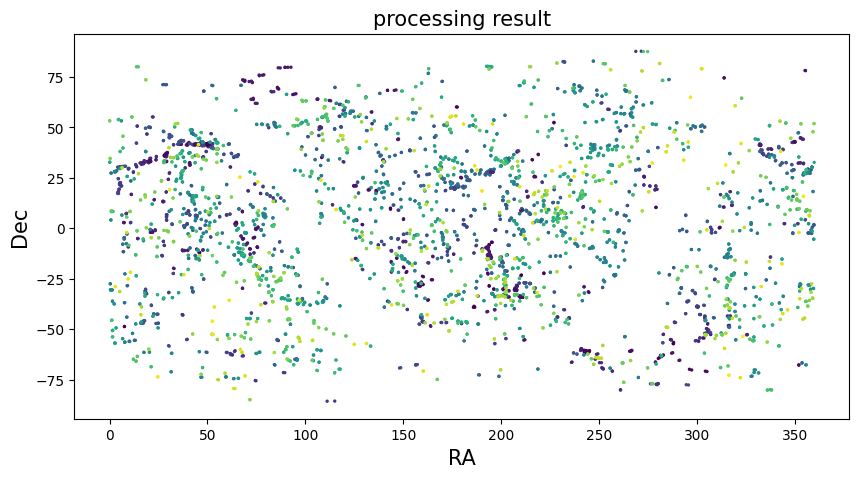

The number of finding particle : 5325


In [10]:
fig = plt.figure(figsize=(10,5))
plt.scatter(result[:,1],result[:,2],s=2,cmap='viridis',c=result[:,4])
plt.xlabel("RA",fontsize=15)
plt.ylabel('Dec',fontsize=15)
plt.title("processing result",fontsize=15)
plt.show()

print("The number of finding particle :",len(result[:,0]) )

In [49]:
dir0 =  "/data/ehddbs98/fof_file/"
file = pd.read_hdf(dir0+"TakeThis.hdf")
lst = np.where(np.array(file['redshift']) >= 10**(-0.85))[0].astype(int)

df = pd.DataFrame({'ra':np.array(file['RA'])[lst],'dec':np.array(file['Dec'])[lst],
        'redshift':np.array(file['z_int'])[lst],'ID':np.arange(len(lst))})
print(df)

                ra        dec  redshift      ID
0        29.402746  -4.428645  0.193609       0
1        28.944212  -2.431221  0.196710       1
2        29.941662  -1.394252  0.194005       2
3        22.952751 -18.534220  0.198448       3
4        25.461468 -20.898151  0.198622       4
...            ...        ...       ...     ...
463601  190.476746  11.150515  0.199971  463601
463602  187.570328  16.767080  0.197938  463602
463603  189.756119  14.663114  0.199001  463603
463604  190.683395  16.627880  0.196590  463604
463605  198.205612  -6.619700  0.197198  463605

[463606 rows x 4 columns]


In [89]:
print(10**(-0.85))

0.14125375446227545


In [51]:
fun.save_file(df,0,5,67.7,0.3,500,dir2)

linkling_angular is 0.05681101567419362 [degree]


In [82]:
np.savetxt(dir2+"whole_data",df)
whole_data = glob.glob(dir2+"whole_data")

In [88]:
%%time

result = [fun.mainloop.remote(i,H0,omegamc,omegalc,omegakc,c,dcondc,vcondc,nmin) for i in whole_data]
whole_results = ray.get(result)

(mainloop pid=92552) start
(mainloop pid=92552) 357.0 mins 20.0 second
CPU times: user 56.6 s, sys: 20.6 s, total: 1min 17s
Wall time: 5h 57min 25s


In [52]:
result = [fun.mainloop.remote(i,H0,omegamc,omegalc,omegakc,c,dcondc,vcondc,nmin) for i in parallel_field_file]
parallel_results = ray.get(result)

(mainloop pid=92553) start
(mainloop pid=92552) start
(mainloop pid=92550) start
(mainloop pid=92554) start
(mainloop pid=92551) start
(mainloop pid=92554) 3.0 mins 35.0 second
(mainloop pid=92553) 3.0 mins 44.0 second
(mainloop pid=92552) 22.0 mins 44.0 second
(mainloop pid=92551) 23.0 mins 38.0 second
(mainloop pid=92550) 35.0 mins 4.0 second


In [70]:
result = [fun.mainloop.remote(i,H0,omegamc,omegalc,omegakc,c,dcondc,vcondc,nmin) for i in common_field_file]
common_results_results = ray.get(result)

(mainloop pid=92553) start
(mainloop pid=92552) start
(mainloop pid=92550) start
(mainloop pid=92551) start
(mainloop pid=92553) 0.0 mins 0.0 second
(mainloop pid=92551) 0.0 mins 0.0 second
(mainloop pid=92552) 0.0 mins 0.0 second
(mainloop pid=92550) 0.0 mins 0.0 second


In [90]:
a = 0
for i in parallel_field_file:
    a+= len(np.loadtxt(i))
print(a)

463606
